<a href="https://colab.research.google.com/github/hhduke2014/marked-beetle-analysis/blob/main/0823EfficientNetB5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import glob
import shutil
import json
import keras
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from keras.preprocessing.image import ImageDataGenerator

import cv2
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
filenames = os.listdir("/content/drive/MyDrive/MarkedBeetleImageAnalysis")
filenames[:4]

['HumanClassifier',
 'PaperedControl21v_light.tif',
 'PaperedControl21d.tif',
 'PaperedControl21d_light.tif']

In [4]:
train_images=[]
for filename in filenames:
    if 'light' not in filename:
      if filename.startswith('Papered') or filename.startswith('NoPapered'):
        train_images.append(filename)
print(f"Number of Train images: {len(train_images)}") #filename.startswith('Pink')

Number of Train images: 757


In [5]:
test_images=[]
for filename in filenames:
    if filename.startswith('Trap'):
        test_images.append(filename)
print(f"Number of Test images: {len(test_images)}")

Number of Test images: 77


In [6]:
categories = []
for filename in train_images:
    if filename.startswith('Papered') or filename.startswith('Pink') or filename.startswith('Trap'):
        categories.append('marked')
    if filename.startswith('NoPapered'):
        categories.append('unmarked')
len(categories)

757

In [7]:
df = pd.DataFrame({
    'filename': train_images,
    'category': categories
})
df

,filename,category
0,PaperedControl21d.tif,marked
1,PaperedControl22v.tif,marked
2,PaperedControl22d.tif,marked
3,PaperedControl23v.tif,marked
4,PaperedControl23d.tif,marked
...,...,...
752,PaperedControl19v.tif,marked
753,PaperedControl19d.tif,marked
754,PaperedControl20v.tif,marked
755,PaperedControl20d.tif,marked


In [8]:
df['category'].value_counts()

marked      479
unmarked    278
Name: category, dtype: int64

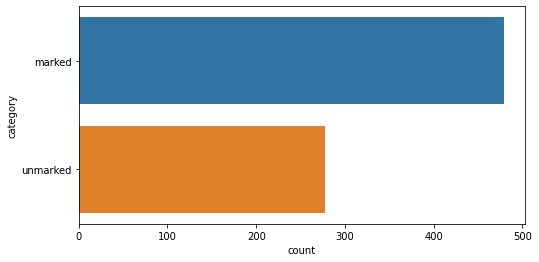

In [9]:
plt.figure(figsize=(8, 4))
sns.countplot(y="category", data=df);

In [11]:
image = cv2.imread(os.path.join("/content/drive/MyDrive/MarkedBeetleImageAnalysis", filenames[1]))
image.shape

(1944, 2592, 3)

In [12]:
def visualize_batch(image_ids, labels):
    plt.figure(figsize=(16, 12))
    for ind, (image_id, label) in enumerate(zip(image_ids, labels)):
        plt.subplot(3, 3, ind+1 )
        image = cv2.imread(os.path.join("/content/drive/MyDrive/MarkedBeetleImageAnalysis", image_id))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.imshow(image)
        plt.title(f"{label}", fontsize=12)
        plt.axis("off")
    
    plt.show()

In [13]:
tmp_df = df.sample(9)
tmp_df

,filename,category
349,NoPaperedGreen30d.tif,unmarked
491,NoPaperedGreen88d.tif,unmarked
535,NoPaperedMixed25d.tif,unmarked
689,NoPaperedMixed2v.tif,unmarked
387,NoPaperedGreen39d.tif,unmarked
675,PaperedMixed45d.tif,marked
437,NoPaperedGreen61d.tif,unmarked
429,NoPaperedGreen57d.tif,unmarked
548,NoPaperedMixed32v.tif,unmarked


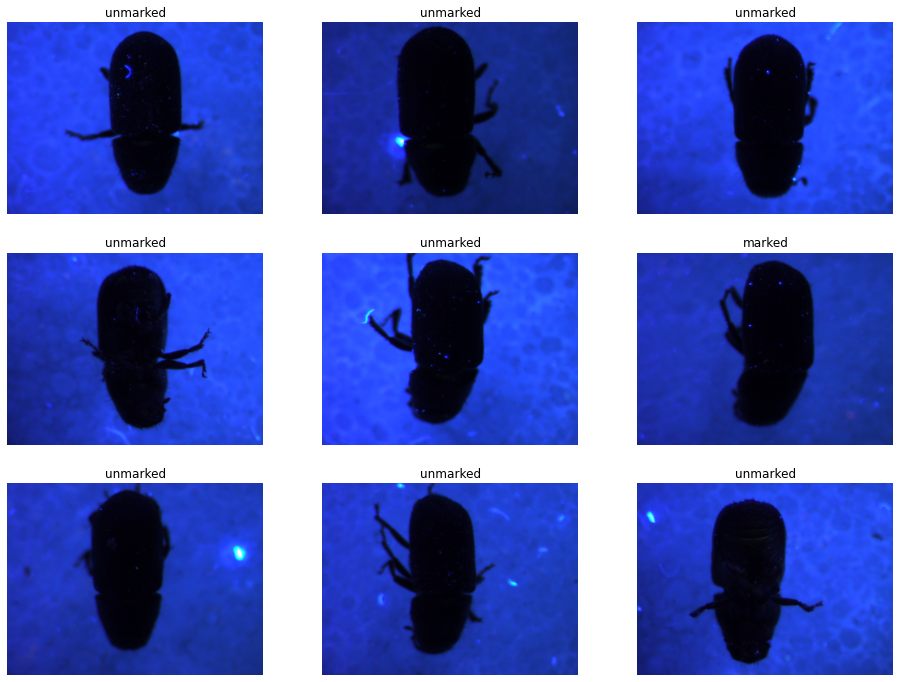

In [14]:
image_ids = tmp_df["filename"].values
labels = tmp_df["category"].values

visualize_batch(image_ids, labels)

In [15]:
#df["category"] = df["category"].replace({0: 'NotMarked', 1: 'Marked'}) 

In [16]:
train_df, validate_df = train_test_split(df, test_size = 0.20, random_state = 42, stratify = df['category'])
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

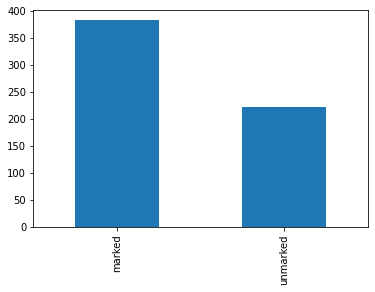

In [17]:
train_df['category'].value_counts().plot.bar()

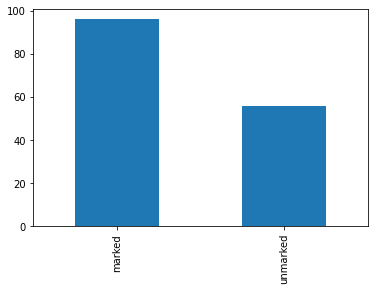

In [18]:
validate_df['category'].value_counts().plot.bar()

In [19]:
IMG_SIZE = 456
size = (IMG_SIZE,IMG_SIZE)
n_CLASS = 2
BATCH_SIZE = 15

In [ ]:
datagen_train = ImageDataGenerator(
                    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    rotation_range = 40,
                    #brightness_range = [0.3,0.9],
                    #channel_shift_range = 50.0,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    horizontal_flip = True,
                    vertical_flip = True,
                    fill_mode = 'nearest')

In [ ]:
datagen_val = ImageDataGenerator(
                    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    )

In [ ]:
train_set = datagen_train.flow_from_dataframe(train_df,
                             directory = "/content/drive/MyDrive/MarkedBeetleImageAnalysis",
                             seed=42,
                             x_col = 'filename',
                             y_col = 'category',
                             target_size = size,
                             #color_mode="rgb",
                             class_mode = 'categorical',
                             interpolation = 'nearest',
                             shuffle = True,
                             batch_size = BATCH_SIZE)

Found 605 validated image filenames belonging to 2 classes.


In [ ]:
validate_set = datagen_val.flow_from_dataframe(validate_df,
                             directory = "/content/drive/MyDrive/MarkedBeetleImageAnalysis",
                             seed=42,
                             x_col = 'filename',
                             y_col = 'category',
                             target_size = size,
                             #color_mode="rgb",
                             class_mode = 'categorical',
                             interpolation = 'nearest',
                             shuffle = True,
                             batch_size = BATCH_SIZE)

Found 152 validated image filenames belonging to 2 classes.


In [ ]:
from tensorflow.keras import layers
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

In [ ]:
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import  Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB5,resnet50,EfficientNetB3
def create_model():
  base = EfficientNetB5(weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3))
        # Freeze the pretrained weights resnet50.ResNet50
  base.trainable = False
  #for layer in base.layers[:-40]:  # Training just part of the architecture do not optimize the performance
      #layer.trainable = False
  model = Sequential()
  model.add(base)
  model.add(GlobalAveragePooling2D())
  model.add(Flatten())
  model.add(BatchNormalization())
  #model.add(Flatten())
  model.add(Dense(128, activation = 'relu', bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)))
  model.add(Dropout(0.5))
  model.add(Dense(2, activation='softmax'))
  return model
model = create_model()
model.summary()

115277824/115263384 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb5 (Functional)  (None, 15, 15, 2048)      28513527  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_______________________________________________________

In [ ]:
EPOCHS = 20
STEP_SIZE_TRAIN = train_set.n//train_set.batch_size
STEP_SIZE_VALID = validate_set.n//validate_set.batch_size

In [ ]:
def Model_fit():
    
    model = create_model()
    '''Compiling the model'''
    #unfreeze_model(model)
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits = False,
                                                   label_smoothing=0.0001,
                                                   name='categorical_crossentropy' )
    
    model.compile(optimizer = Adam(learning_rate = 1e-3),
                        loss = loss, #'categorical_crossentropy'
                        metrics = ['accuracy']) #'acc'
    
        # Stop training when the val_loss has stopped decreasing for 3 epochs.
    stop = EarlyStopping(monitor='val_loss', mode='min', patience=3,
                       restore_best_weights=True, verbose=1)
    
    # Save the model with the minimum validation loss
    checkpoint_cb = ModelCheckpoint("23efficient_model.h5",
                                    save_best_only=True,
                                    monitor = 'val_loss',
                                    mode='min')
    
    # reduce learning rate
    reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                                  factor = 0.2,
                                  patience = 2,
                                  min_lr = 1e-6,
                                  mode = 'min',
                                  verbose = 1)
    history = model.fit(train_set,
                             validation_data = validate_set,
                             epochs= EPOCHS,
                             batch_size = BATCH_SIZE,
                             #class_weight = d_class_weights,
                             steps_per_epoch = STEP_SIZE_TRAIN,
                             validation_steps = STEP_SIZE_VALID,
                             callbacks=[stop, checkpoint_cb, reduce_lr])
    model.save('model'+'.h5')  
    return history

In [ ]:
results = Model_fit()

Epoch 1/20
40/40 [==============================] - 957s 23s/step - loss: 0.9078 - accuracy: 0.6932 - val_loss: 0.5425 - val_accuracy: 0.6800


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
40/40 [==============================] - 812s 20s/step - loss: 0.7664 - accuracy: 0.7508 - val_loss: 0.5128 - val_accuracy: 0.6867
Epoch 3/20
40/40 [==============================] - 827s 21s/step - loss: 0.6259 - accuracy: 0.7797 - val_loss: 0.4292 - val_accuracy: 0.8667
Epoch 4/20
40/40 [==============================] - 871s 22s/step - loss: 0.5771 - accuracy: 0.8068 - val_loss: 0.4123 - val_accuracy: 0.8267
Epoch 5/20
40/40 [==============================] - 842s 21s/step - loss: 0.5996 - accuracy: 0.7881 - val_loss: 0.4230 - val_accuracy: 0.7600
Epoch 6/20
40/40 [==============================] - 869s 22s/step - loss: 0.4875 - accuracy: 0.8136 - val_loss: 0.4009 - val_accuracy: 0.8267
Epoch 7/20
40/40 [==============================] - 857s 21s/step - loss: 0.4216 - accuracy: 0.8237 - val_loss: 0.4398 - val_accuracy: 0.7533
Epoch 8/20
40/40 [==============================] - 844s 21s/step - loss: 0.4349 - accuracy: 0.8220 - val_loss: 0.3541 - val_accuracy: 0.8133
Epoch 

In [ ]:
print('Train_Cat-Acc: ', max(results.history['accuracy']))
print('Val_Cat-Acc: ', max(results.history['val_accuracy']))

Train_Cat-Acc:  0.8593220114707947
Val_Cat-Acc:  0.8799999952316284


In [ ]:
print('Train_Cat-Loss: ', min(results.history['loss']))
print('Val_Cat-Loss: ', min(results.history['val_loss']))

Train_Cat-Loss:  0.302520751953125
Val_Cat-Loss:  0.2803363502025604


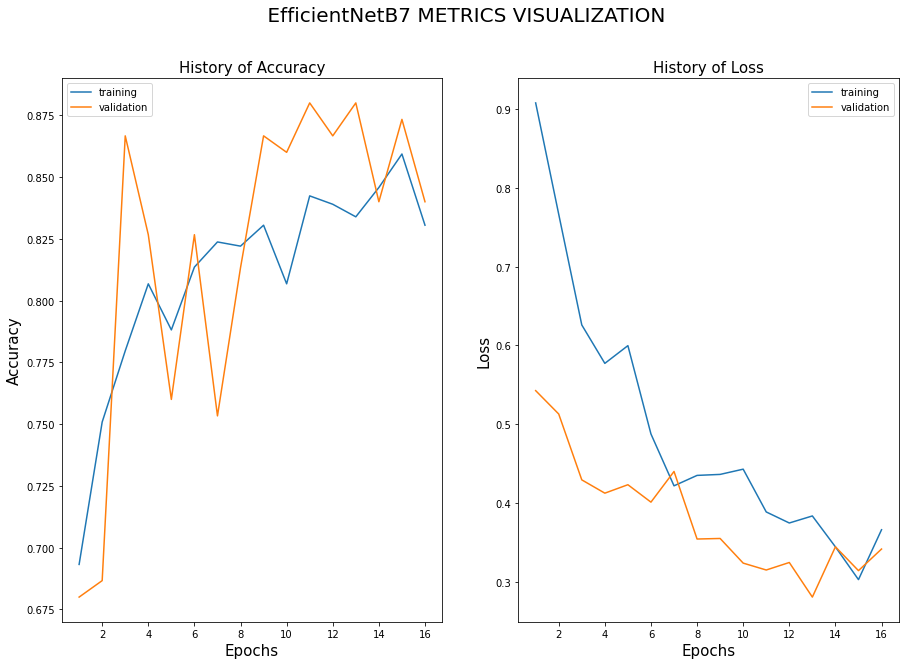

In [ ]:
def Train_Val_Plot(acc,val_acc,loss,val_loss):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,10))
    fig.suptitle(" EfficientNetB7 METRICS VISUALIZATION ", fontsize=20)

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy', fontsize=15)
    ax1.set_xlabel('Epochs', fontsize=15)
    ax1.set_ylabel('Accuracy', fontsize=15)
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss', fontsize=15)
    ax2.set_xlabel('Epochs', fontsize=15)
    ax2.set_ylabel('Loss', fontsize=15)
    ax2.legend(['training', 'validation'])
    plt.show()
    

Train_Val_Plot(results.history['accuracy'],results.history['val_accuracy'],
               results.history['loss'],results.history['val_loss'])

In [20]:
import keras

final_model = keras.models.load_model('23efficient_model.h5')

In [ ]:
tmp_df1=df.sample(10)
tmp_df1

,filename,category
657,PaperedMixed35d.tif,marked
238,PaperedTransparent60v.tif,marked
732,NoPaperedGreen7v.tif,unmarked
682,PaperedMixed48v.tif,marked
393,NoPaperedGreen32d.tif,unmarked
669,PaperedMixed41d.tif,marked
421,NoPaperedGreen52d.tif,unmarked
54,PaperedControl47d.tif,marked
194,PaperedTransparent38v.tif,marked
314,PaperedTransparent98v.tif,marked


In [21]:
nb_samples = df.shape[0]

In [22]:
test_gen = ImageDataGenerator(preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    #rotation_range = 40,
                    #brightness_range = [0.3,0.9],
                    #channel_shift_range = 50.0,
                    #width_shift_range = 0.2,
                    #height_shift_range = 0.2,
                    #shear_range = 0.2,
                    #zoom_range = 0.2,
                    #horizontal_flip = True,
                    #vertical_flip = True,
                    #fill_mode = 'nearest'
                    )
test_generator = test_gen.flow_from_dataframe(
    df, 
    "/content/drive/MyDrive/MarkedBeetleImageAnalysis/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=size,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 757 validated image filenames.


In [23]:
predictdf = final_model.predict(test_generator, steps=np.ceil(nb_samples/BATCH_SIZE))

In [24]:
df['prediction'] = np.argmax(predictdf, axis=-1)
df["prediction"] = df["prediction"].replace({1: 'unmarked', 0: 'marked'}) 
df

,filename,category,prediction
0,PaperedControl21d.tif,marked,marked
1,PaperedControl22v.tif,marked,marked
2,PaperedControl22d.tif,marked,marked
3,PaperedControl23v.tif,marked,marked
4,PaperedControl23d.tif,marked,marked
...,...,...,...
752,PaperedControl19v.tif,marked,marked
753,PaperedControl19d.tif,marked,marked
754,PaperedControl20v.tif,marked,marked
755,PaperedControl20d.tif,marked,marked


In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_true=list(df['category'])
y_pred=list(df['prediction'])
cm1=confusion_matrix(y_true, y_pred, labels=["marked", "unmarked"])

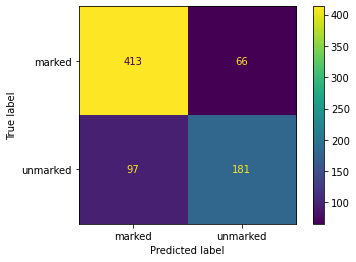

In [26]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=["marked", "unmarked"])
disp.plot(values_format="d") 

In [ ]:
to_samples = validate_df.shape[0]

In [ ]:
test_gen = ImageDataGenerator(preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    #rotation_range = 40,
                    #brightness_range = [0.3,0.9],
                    #channel_shift_range = 50.0,
                    #width_shift_range = 0.2,
                    #height_shift_range = 0.2,
                    #shear_range = 0.2,
                    #zoom_range = 0.2,
                    #horizontal_flip = True,
                    #vertical_flip = True,
                    #fill_mode = 'nearest'
                    )
test_generator1 = test_gen.flow_from_dataframe(
    validate_df, 
    "/content/drive/MyDrive/MarkedBeetleImageAnalysis/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=size,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 152 validated image filenames.


In [ ]:
predict = final_model.predict(test_generator1, steps=np.ceil(to_samples/BATCH_SIZE))

In [ ]:
predict

array([[1.36194125e-01, 8.63805890e-01],
       [5.38766146e-01, 4.61233854e-01],
       [9.39724296e-02, 9.06027496e-01],
       [5.29975653e-01, 4.70024377e-01],
       [4.89452690e-01, 5.10547280e-01],
       [6.54024661e-01, 3.45975280e-01],
       [9.00481105e-01, 9.95189250e-02],
       [8.55258942e-01, 1.44741073e-01],
       [2.81213641e-01, 7.18786299e-01],
       [2.67019093e-01, 7.32980907e-01],
       [3.20417970e-01, 6.79582000e-01],
       [4.91358072e-01, 5.08641899e-01],
       [1.93816692e-01, 8.06183279e-01],
       [3.62113148e-01, 6.37886822e-01],
       [3.46697837e-01, 6.53302073e-01],
       [6.49678648e-01, 3.50321293e-01],
       [6.84103251e-01, 3.15896779e-01],
       [7.09464133e-01, 2.90535897e-01],
       [5.27001858e-01, 4.72998172e-01],
       [5.87804317e-01, 4.12195712e-01],
       [9.90045726e-01, 9.95428395e-03],
       [9.90187943e-01, 9.81205981e-03],
       [9.99461353e-01, 5.38623892e-04],
       [8.98144841e-01, 1.01855211e-01],
       [3.338039

In [ ]:
validate_df['prediction'] = np.argmax(predict, axis=1)
validate_df["prediction"] = validate_df["prediction"].replace({1: 'unmarked', 0: 'marked'}) 
validate_df

,filename,category,prediction
0,PaperedControl45d.tif,marked,unmarked
1,NoPaperedMixed38v.tif,unmarked,marked
2,NoPaperedGreen43v.tif,unmarked,unmarked
3,NoPaperedMixed7v.tif,unmarked,marked
4,PaperedTransparent8d.tif,marked,unmarked
...,...,...,...
147,PaperedTransparent99v.tif,marked,marked
148,NoPaperedGreen61v.tif,unmarked,unmarked
149,NoPaperedGreen57d.tif,unmarked,unmarked
150,PaperedControl64d.tif,marked,marked


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_true=list(validate_df['category'])
y_pred=list(validate_df['prediction'])
cm=confusion_matrix(y_true, y_pred, labels=["marked", "unmarked"])

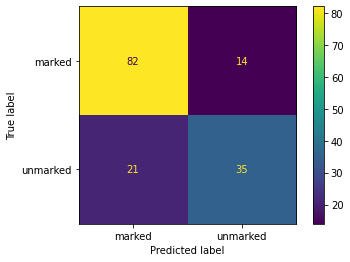

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["marked", "unmarked"])
disp.plot(values_format="d") 

In [ ]:
final_modell = keras.models.load_model('best_model.h5')

OSError: ignored

In [ ]:
preds=[]
for image_id in tmp_df1.filename:
  image = Image.open(os.path.join("/content/drive/MyDrive/MarkedBeetleImageAnalysis/",image_id))
  image = image.resize((600,600))
  image = np.expand_dims(image,axis=0)
  preds.append(np.argmax(final_modell.predict(image)))
tmp_df1["prediction1"]=preds

In [ ]:
tmp_df1["prediction1"] = tmp_df1["prediction1"].replace({1: 'unmarked', 0: 'marked'}) 
tmp_df1